In [1]:
import sys
import os
import scipy.io
import numpy as np
import json
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
from PIL import Image
import tifffile

import dataclasses

In [2]:
# Add the common directory to path
sys.path.append(os.path.abspath('../common'))

# Import the common functions
from lidarMath import vmag


In [3]:
class LidarJsonStruct:
    # Constructor (initialization) method
    def __init__(self):
        # Instance attributes (unique to each instance)
        self.trajectoryStr = []
        self.sampleNum = []
        self.timestamp = []
        self.imageName = []

In [4]:
import json
from dataclasses import dataclass, field, asdict
from typing import List


@dataclass
class LidarEntry:
    """Represents a single lidar data entry"""
    trajectoryStr: str
    sampleNum: int
    timestamp: float
    imageName: str
    posVehInNavTruth: list[float]
    azVehInNavTruth: float

@dataclass
class LidarJsonStruct:
    """Collection of lidar data entries that can be serialized to JSON"""
    entries: List[LidarEntry] = field(default_factory=list)
    
    def add_entry(self, trajectory_str: str, sample_num: int, 
                 timestamp: float, image_name: str,
                 posVehInNavTruth: list[float], azVehInNavTruth: float) -> None:
        """Add a new entry to the lidar data structure"""
        entry = LidarEntry(
            trajectoryStr=trajectory_str,
            sampleNum=sample_num,
            timestamp=timestamp,
            imageName=image_name,
            posVehInNavTruth=posVehInNavTruth,
            azVehInNavTruth=azVehInNavTruth
        )
        self.entries.append(entry)
    
    def to_json(self, indent=4) -> str:
        """Convert the entire structure to a JSON string"""
        return json.dumps(asdict(self), indent=indent)
    
    def save_to_file(self, filename: str) -> None:
        """Save the structure to a JSON file"""
        with open(filename, 'w') as f:
            f.write(self.to_json())
    
    @classmethod
    def from_json(cls, json_str: str) -> 'LidarJsonStruct':
        """Create a LidarJsonStruct from a JSON string"""
        data = json.loads(json_str)
        result = cls()
        
        for entry_data in data['entries']:
            result.add_entry(
                entry_data['trajectoryStr'],
                entry_data['sampleNum'],
                entry_data['timestamp'],
                entry_data['imageName'],
                entry_data['posVehInNavTruth'],
                entry_data['azVehInNavTruth']
            )
        return result
    
    @classmethod
    def load_from_file(cls, filename: str) -> 'LidarJsonStruct':
        """Load a LidarJsonStruct from a JSON file"""
        with open(filename, 'r') as f:
            return cls.from_json(f.read())

In [5]:
lidarDataPath = "/home/julian/sandbox/datasets/vt-lidar/All_estimation_input_data_DoubleLoop/"
lidarDataFiles = sorted(os.listdir(lidarDataPath))

In [6]:
# Start Time
startTime = 14.7
startIdx = 148 - 1
finalIdx = 148 + 202 + 1
# finalIdx = 148 + 5

# lidar indices
timestampIdx = 0
azVehIdx = 1
elVehIdx = 2
intPtIdx = 4
lidarXIdx = 5
lidarYIdx = 6
lidarZIdx = 7

# vicon indices
posVehXIdx = 4
posVehYIdx = 5
azVehIdx   = 3

normPts = 2000

img_row = 180; img_col = 360
principalPoint = np.array([(img_row-1) / 2, (img_col-1) / 2])

# Define the rotation angle
rot_ang = -np.pi / 2

# Define the rotation matrix
mRotImg = np.array([[np.cos(rot_ang), -np.sin(rot_ang)], [np.sin(rot_ang), np.cos(rot_ang)]])

KeyboardInterrupt: 

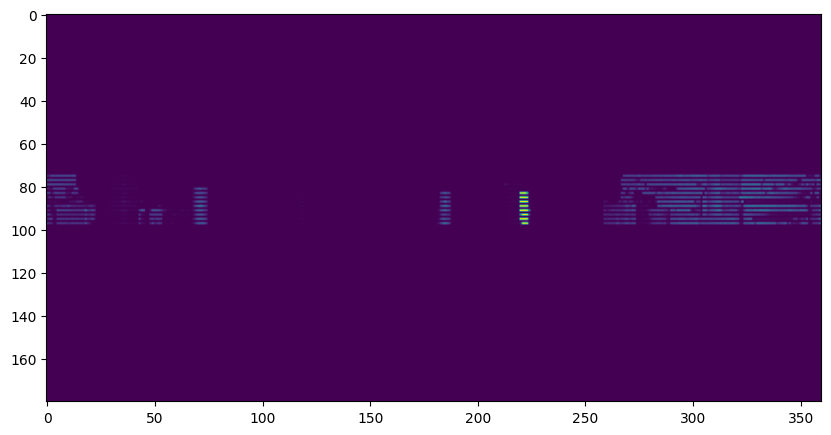

In [7]:
# Create an empty list that will hold dictionaries
lidar = LidarJsonStruct()

# Create figure and axis
plt.figure(figsize=(10, 10))

fileIdx = 0

for fileIdx in range(lidarDataFiles.__len__()):
# for fileIdx in range(1):

  lidarMatData = scipy.io.loadmat("".join([lidarDataPath, lidarDataFiles[fileIdx]]))

  trajStr = lidarDataFiles[fileIdx][:-4]

    # Path to the folder you want to check/create
  folder_path = './images/' + trajStr

  # Check if folder exists
  if not os.path.exists(folder_path):
      # Create folder if it doesn't exist
      os.makedirs(folder_path)
      print(f"Folder '{folder_path}' created successfully")
  else:
      print(f"Folder '{folder_path}' already exists")

  # Map the test data to new variable names
  lidarData = lidarMatData['LiDARpc']
  viconData = lidarMatData['VICONpcSyncTV']
  viconTime = lidarMatData['timeVec']

  print('Processing: ' + trajStr)

  for dataIdx in range(startIdx, finalIdx):
    # Initialize the lidar image
    lidar2DImg = np.zeros([2, img_row, img_col])

    # Pull the timestamp
    timestampLidar = lidarData[dataIdx,0][:,timestampIdx]

    # Pull the intensity of each of the point cloud
    ptCloudInt = lidarData[dataIdx,0][:,intPtIdx]

    # Pull the point cloud
    ptCloud = np.array([lidarData[dataIdx,0][:,lidarXIdx], 
                        lidarData[dataIdx,0][:,lidarYIdx], 
                        lidarData[dataIdx,0][:,lidarZIdx]])

    # ptCloud = ptCloud / normPts

    # Find the closet logged vicon timestamp to the lidar scan's mean timestamp
    viconIdx = np.argmin(np.abs(viconTime[:,0]-np.mean(timestampLidar)))
    posVehInNavTruth = [viconData[dataIdx][posVehXIdx], viconData[dataIdx][posVehYIdx]]

    # Make sure the az wraps around properly so its continuous 
    if ( viconData[dataIdx][azVehIdx] > np.pi/2 ):
      azVehInNavTruth = viconData[dataIdx][azVehIdx]  - 2*np.pi
    else:
      azVehInNavTruth = viconData[dataIdx][azVehIdx] 

    for ptIdx in range(ptCloud.shape[1]):
      pt = ptCloud[:,ptIdx]
      ptInt = ptCloudInt[ptIdx]

      # Calculate the Az and El angle to the point cloud
      el_ary = np.acos( pt[2] / np.linalg.norm(pt))

      if (pt[0] > 0):
        az_ary = np.atan(pt[1] / pt[0])
      elif (pt[0] < 0) & (pt[1] >= 0):
        az_ary = np.atan(pt[1] / pt[0]) + np.pi
      elif (pt[0] < 0) & (pt[1] < 0):
        az_ary = np.atan(pt[1] / pt[0]) - np.pi

      RAD_TO_DEG = 180 / np.pi
      az_deg = az_ary * RAD_TO_DEG + 180
      el_deg = el_ary * RAD_TO_DEG
      
      ptImg = np.int32(np.round([(el_deg - 90) + 90, (az_deg)]))

      if ((ptImg[0] >= 0) & (ptImg[0] < img_row)):
        if ((ptImg[1] >= 0) & (ptImg[1] < img_col)):
          if (lidar2DImg[0, ptImg[0],ptImg[1]] == 0):
            lidar2DImg[0, ptImg[0],ptImg[1]] = np.linalg.norm(pt)
            lidar2DImg[1, ptImg[0],ptImg[1]] = ptInt
          elif (np.linalg.norm(pt) < lidar2DImg[0, ptImg[0],ptImg[1]]):
            lidar2DImg[0, ptImg[0],ptImg[1]] = np.linalg.norm(pt)
            lidar2DImg[1, ptImg[0],ptImg[1]] = ptInt

    # Pull the nth closest point clouds
    imgStr = trajStr + '_sample_' + str(dataIdx) + '.tiff'
    lidar.add_entry(lidarDataFiles[fileIdx], dataIdx, np.mean(timestampLidar), imgStr, posVehInNavTruth, azVehInNavTruth)

    # write the image data
    writePath = folder_path + '/' + imgStr
    tifffile.imwrite(writePath, lidar2DImg)

    # Clear previous output
    clear_output(wait=True)
    
    plt.clf()
    # Show the project lidar points
    plt.imshow(lidar2DImg[1,:,:])

    # This ensures the plot is displayed during the loop

    plt.draw()
    display(plt.gcf())

  plt.close('all') 

  jsonStr = 'lidar_data.json'

  # Check if file exists
  if os.path.exists(jsonStr):
      # Delete the file
      os.remove(jsonStr)
      print("The json file has been deleted")
  else:
      print("The json file does not exist")

  lidar.save_to_file(jsonStr)


In [10]:
print('Processing: ' + trajStr)

Processing: PointsExtraAssoc_07122020onehr_01


In [ ]:
with open(jsonStr, 'r') as file:
    lidar_data = json.load(file)

In [ ]:
lidar_data

{'entries': [{'trajectoryStr': 'PointsExtraAssoc_07122020onehr_01.mat',
   'sampleNum': 147,
   'timestamp': 69773.35951929551,
   'imageName': 'PointsExtraAssoc_07122020onehr_01_sample_147.tiff',
   'posVehInNavTruth': [-261.137, -1811.6486],
   'azVehInNavTruth': -1.8412},
  {'trajectoryStr': 'PointsExtraAssoc_07122020onehr_01.mat',
   'sampleNum': 148,
   'timestamp': 69773.46052825045,
   'imageName': 'PointsExtraAssoc_07122020onehr_01_sample_148.tiff',
   'posVehInNavTruth': [-213.1689, -1824.5144],
   'azVehInNavTruth': -1.7855},
  {'trajectoryStr': 'PointsExtraAssoc_07122020onehr_01.mat',
   'sampleNum': 149,
   'timestamp': 69773.5615105753,
   'imageName': 'PointsExtraAssoc_07122020onehr_01_sample_149.tiff',
   'posVehInNavTruth': [-162.6816, -1839.7823],
   'azVehInNavTruth': -1.7202},
  {'trajectoryStr': 'PointsExtraAssoc_07122020onehr_01.mat',
   'sampleNum': 150,
   'timestamp': 69773.66270335013,
   'imageName': 'PointsExtraAssoc_07122020onehr_01_sample_150.tiff',
   'pos

In [ ]:
posVehInNavTruthAry = []
azVehInNavTruthAry = []
for entries in lidar_data['entries']:
    posVehInNavTruth = entries['posVehInNavTruth']
    azVehInNavTruth = entries['azVehInNavTruth']
    posVehInNavTruthAry.append(posVehInNavTruth)
    azVehInNavTruthAry.append(azVehInNavTruth)

posVehInNavTruthAry = np.array(posVehInNavTruthAry)
azVehInNavTruthAry = np.array(azVehInNavTruthAry)

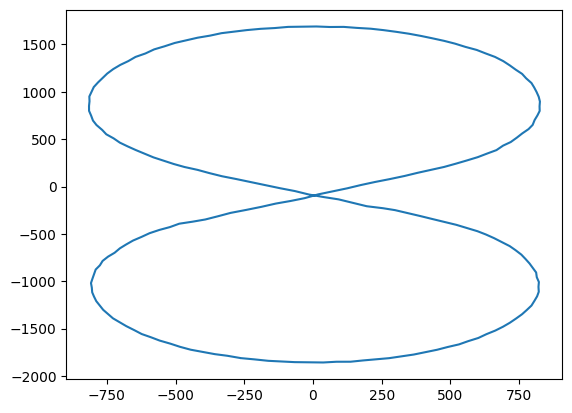

In [ ]:
plt.plot(posVehInNavTruthAry[:,0], posVehInNavTruthAry[:,1])

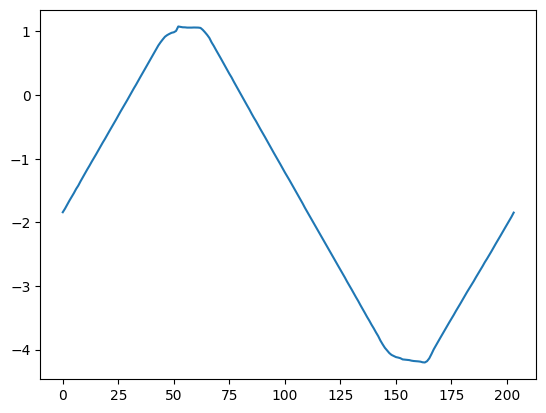

In [ ]:
plt.plot(azVehInNavTruthAry)